In [45]:
import tensorcircuit as tc
import jax.numpy as np
import optax
from tensorcircuit . experimental import qng
from functools import partial

In [2]:
backend = tc.set_backend("jax")
tc.set_dtype("complex128")
tc.set_contractor("auto")  # “auto”, “greedy”, “branch”, “plain”, “tng”, “custom”

functools.partial(<function custom at 0x137d17940>, optimizer=<function auto at 0x10f011670>, memory_limit=None, debug_level=0)

In [ ]:
n = 4
k = 3
#
params = backend.implicit_randn([3 * n, k + 1], dtype="complex")

def sensor(params, phi):
    p = 0.0
    dmc = tc.Circuit(n)

    params_probe = params[:, 0:-1]
    params_measure = params[:, -1:]

    # probe state
    # for layer in range(k):
    #     for i in range(n):
    #         dmc.r(i, theta=params_probe[i * 3, k],
    #               alpha=params_probe[i])
    #     for i in range(1, n):
    #         dmc.cnot(i-1, i)
    #     for i in range(n):
    #         dmc.depolarizing(i, px=p, py=p, pz=p)
    dmc.h(0)
    for i in range(1, n):
        dmc.cnot(0, i)

    # interaction
    for i in range(n):
        dmc.rz(i, theta = phi)

    # measurement
    # for i in range(n):
    #     dmc.rx(i, theta=params_measure[i * 3, 0])
    #     dmc.ry(i, theta=params_measure[i * 3 + 1, 0])
    #     dmc.rz(i, theta=params_measure[i * 3 + 1, 0])

    return dmc.densitymatrix()


def cfi(params, phi):

    def prob(params, phi):
        dm = sensor(params, phi)
        return backend.real(backend.diagonal(dm))

    p = prob(params, phi)
    # dprob = backend.jit(backend.jacrev(lambda phi: prob(params=params, phi=phi)))
    dprob = backend.jacrev(lambda phi: prob(params=params, phi=phi))
    print(dprob(phi))
    print(dprob(phi).squeeze())
    fi = backend.sum((dprob(phi).squeeze()) ** 2 / p)
    return fi


# phi = np.array([1.12314])
phi = backend.implicit_randn()
print(cfi(params, phi))

In [ ]:
n = 4
k = 3
#
params = backend.implicit_randn([3 * n, k + 1])

def sensor(params, phi):
    p = 0.0
    # dmc = tc.Circuit(n)
    dmc = tc.DMCircuit(n)

    params_probe = params[:, 0:-1]
    params_measure = params[:, -1:]

    # probe state
    for layer in range(k):
        for i in range(n):
            dmc.r(i,
                  theta=params_probe[3*i, k],
                  alpha=params_probe[3*i + 1, k],
                  phi = params_probe[3*i + 2, k])
        for i in range(1, n):
            dmc.cnot(0, i)
    #     for i in range(n):
    #         dmc.depolarizing(i, px=p, py=p, pz=p)

    # dmc.h(0)
    # for i in range(1, n):
    #     dmc.cnot(0, i)

    # interaction
    for i in range(n):
        dmc.rx(i, theta = phi)

    # measurement
    for i in range(n):
        dmc.r(i,
              theta=params_measure[3*i, 0],
              alpha=params_measure[3*i + 1, 0],
              phi = params_measure[3*i + 2, 0])

    #     dmc.rx(i, theta=params_measure[i * 3, 0])
    #     dmc.ry(i, theta=params_measure[i * 3 + 1, 0])
    #     dmc.rz(i, theta=params_measure[i * 3 + 1, 0])

    return dmc.densitymatrix()
    # return dmc.wavefunction()


def cfi(params, phi):

    def prob(params, phi):
        dm = sensor(params, phi)
        return backend.real(backend.diagonal(dm))
        # return backend.real(dm)

    p = prob(params, phi)
    # dprob = backend.jit(backend.jacrev(lambda phi: prob(params=params, phi=phi)))
    dprob = backend.jacrev(lambda phi: prob(params=params, phi=phi))
    # print(dprob(phi))
    # print(dprob(phi).squeeze())
    fi = backend.sum((dprob(phi).squeeze()) ** 2 / p)
    return fi

print(backend.sum(backend.abs(sensor(params, phi))**2))
# phi = np.array([1.12314])
# phi = backend.implicit_randn()
# print(cfi(params, phi))

In [ ]:
cfi_val_grad_jit = backend.jit(backend.value_and_grad(lambda params: -cfi(params=params, _phi=phi)))
val, grad = cfi_val_grad_jit(params)

In [ ]:
opt = tc.backend.optimizer(optax.adagrad(learning_rate=0.95))


In [ ]:
params = backend.implicit_randn([3 * n, k + 1])

for i in range(250):
    val, grad = cfi_val_grad_jit(params)
    params = opt.update(grad, params)
    print(f"Step {i} | CFI {val}")
    # print(params)

In [ ]:
# %timeit noisy(4)

In [ ]:
n = 6
k = 4
#
params = backend.implicit_randn([3 * n, k]).astype("complex")


def sensor(params, phi):
    dmc = tc.Circuit(n)

    for i in range(k):
        for j in range(n):
            dmc.r(j, theta=params[3*j, i], alpha=params[3*j + 1, i], phi=params[3*j + 2, i])

        for j in range(1, n):
            dmc.cnot(j-1, j)

    # interaction
    for j in range(n):
        dmc.rz(j, theta = phi)
    return dmc

phi = np.array([1.12314]).astype("complex")
params = backend.implicit_randn([3 * n, k])

dmc = sensor(params, phi)
dmc.draw(output="text")


def qfi(_params, phi):
    psi = sensor(_params, phi).state()[:, None]
    f_dpsi_phi = backend.jacrev(lambda phi: sensor(params=_params, phi=phi).state())
    d_psi = f_dpsi_phi(phi)
    fi = 4 * backend.real((backend.conj(d_psi.T) @ d_psi) + (backend.conj(d_psi.T) @ psi)**2)
    return fi[0, 0]


In [ ]:
dmc.draw(output="text")

In [ ]:
qfi_val_grad_jit = backend.jit(backend.value_and_grad(lambda params: -qfi(_params=params, phi=phi)))
val, grad = qfi_val_grad_jit(params)
print(val, grad)

In [ ]:
opt = tc.backend.optimizer(optax.adagrad(learning_rate=0.35))

params = backend.implicit_randn([3 * n, k])

for i in range(250):
    val, grad = qfi_val_grad_jit(params)
    # print(grad)
    params = opt.update(grad, params)
    print(f"Step {i} | QFI {val}")
    # print(params)

# CFI

In [62]:
n = 6
k = 4

def sensor(params, phi):
    dmc = tc.Circuit(n)

    for i in range(k):
        for j in range(n):
            dmc.r(j, theta=params[3*j, i], alpha=params[3*j + 1, i], phi=params[3*j + 2, i])

        for j in range(1, n):
            dmc.cnot(j-1, j)

    for j in range(n):
        dmc.r(j, theta=params[3*j, i], alpha=params[3*j + 1, i], phi=params[3*j + 2, i])

    # interaction
    for j in range(n):
        dmc.rz(j, theta = phi)

    # measurement
    for j in range(n):
        dmc.u(j, theta = params[3*j, -1], phi=params[3*j + 1, -1])

    return dmc


phi = np.array([1.12314])
params = backend.implicit_randn([3 * n, k+1])

dmc = sensor(params, phi)

def cfi(_params, _phi):
    def probs(_params, _phi):
        return backend.abs(sensor(_params, _phi).state())**2
    pr = probs(_params, _phi)
    dpr_phi = backend.jacrev(lambda _phi: probs(_params=_params, _phi=_phi))
    d_pr = dpr_phi(phi).squeeze()
    fim = backend.sum(d_pr * d_pr / pr)
    return fim

print(cfi(params, phi))


0.6394717310835949


In [63]:
dmc.draw(output="text")

┌───┐     ┌───┐          ┌───┐          ┌───┐          ┌───┐┌────────────┐»
q_0: ┤ r ├──■──┤ r ├───────■──┤ r ├───────■──┤ r ├───────■──┤ r ├┤ Rz(1.1231) ├»
     ├───┤┌─┴─┐└───┘┌───┐┌─┴─┐└───┘┌───┐┌─┴─┐└───┘┌───┐┌─┴─┐└───┘└───┬───┬────┘»
q_1: ┤ r ├┤ X ├──■──┤ r ├┤ X ├──■──┤ r ├┤ X ├──■──┤ r ├┤ X ├──■──────┤ r ├─────»
     ├───┤└───┘┌─┴─┐└───┘├───┤┌─┴─┐└───┘├───┤┌─┴─┐└───┘├───┤┌─┴─┐    └───┘     »
q_2: ┤ r ├─────┤ X ├──■──┤ r ├┤ X ├──■──┤ r ├┤ X ├──■──┤ r ├┤ X ├──────■───────»
     ├───┤     └───┘┌─┴─┐└───┘├───┤┌─┴─┐└───┘├───┤┌─┴─┐└───┘├───┤    ┌─┴─┐     »
q_3: ┤ r ├──────────┤ X ├──■──┤ r ├┤ X ├──■──┤ r ├┤ X ├──■──┤ r ├────┤ X ├─────»
     ├───┤          └───┘┌─┴─┐└───┘├───┤┌─┴─┐└───┘├───┤┌─┴─┐└───┘    ├───┤     »
q_4: ┤ r ├───────────────┤ X ├──■──┤ r ├┤ X ├──■──┤ r ├┤ X ├──■──────┤ r ├─────»
     ├───┤               └───┘┌─┴─┐├───┤└───┘┌─┴─┐├───┤└───┘┌─┴─┐    ├───┤     »
q_5: ┤ r ├────────────────────┤ X ├┤ r ├─────┤ X ├┤ r ├─────┤ X ├────┤ r ├─────»
     └───┘                    └───┘└───┘     └───┘└───┘     └───┘    └───┘     »
«     ┌──────────────────────┐                                                »
«q_0: ┤ U(0.60655,0.64269,0) ├────────────────────────────────────────────────»
«     └────┬────────────┬────┘┌──────────────────────┐                        »
«q_1: ─────┤ Rz(1.1231) ├─────┤ U(-1.6219,-1.6442,0) ├────────────────────────»
«          └───┬───┬────┘     └────┬────────────┬────┘┌──────────────────────┐»
«q_2: ─────────┤ r ├───────────────┤ Rz(1.1231) ├─────┤ U(0.042759,1.6253,0) ├»
«              └───┘               └───┬───┬────┘     └────┬────────────┬────┘»
«q_3: ───────────■─────────────────────┤ r ├───────────────┤ Rz(1.1231) ├─────»
«              ┌─┴─┐                   └───┘               └───┬───┬────┘     »
«q_4: ─────────┤ X ├─────────────────────■─────────────────────┤ r ├──────────»
«              └───┘                   ┌─┴─┐                   ├───┤          »
«q_5: ─────────────────────────────────┤ X ├───────────────────┤ r ├──────────»
«                                      └───┘                   └───┘          »
«                                                     
«q_0: ────────────────────────────────────────────────
«                                                     
«q_1: ────────────────────────────────────────────────
«                                                     
«q_2: ────────────────────────────────────────────────
«     ┌─────────────────────┐                         
«q_3: ┤ U(1.1439,-1.1712,0) ├─────────────────────────
«     └────┬────────────┬───┘ ┌──────────────────────┐
«q_4: ─────┤ Rz(1.1231) ├─────┤ U(0.40447,0.46257,0) ├
«          ├────────────┤    ┌┴──────────────────────┤
«q_5: ─────┤ Rz(1.1231) ├────┤ U(-0.75684,0.29936,0) ├
«          └────────────┘    └───────────────────────┘

In [64]:
cfi_val_grad_jit = backend.jit(backend.value_and_grad(lambda params: -cfi(_params=params, _phi=phi)))
val, grad = cfi_val_grad_jit(params)
print(val, grad)

-0.6394717310835949 [[ 5.18865168e-01 -6.11652255e-01  8.16755183e-03  5.30412495e-02
  -4.49732132e-02]
 [ 1.15116306e-01  3.28251682e-02  1.25711054e-01  2.40929276e-02
   1.61329283e-16]
 [-1.63690925e-01  1.16701452e-02  1.72127262e-01  4.79627214e-03
   0.00000000e+00]
 [-1.94282010e-02 -1.98114067e-01  1.32799104e-01  1.51566472e-02
   9.41578299e-03]
 [-2.73651898e-01 -9.14896876e-02 -1.37297630e-01  2.43475050e-01
   7.63278329e-17]
 [ 1.41687365e-03  3.02134128e-03  6.01618551e-04  3.70453298e-03
   0.00000000e+00]
 [ 3.03009659e-01 -6.77434623e-01 -7.13985264e-01 -1.42582804e-01
  -4.15211141e-01]
 [ 1.50111970e-02 -1.13205642e-01 -2.80193567e-01 -1.37435943e-01
   2.60208521e-17]
 [-3.83593887e-03 -1.34522796e-01  5.09209409e-02  1.66091055e-01
   0.00000000e+00]
 [ 4.89116937e-01  1.63508490e-01  2.25313216e-01 -4.13548231e-01
  -2.58194387e-01]
 [ 3.97523820e-01  1.12787612e-01  8.18160027e-02 -7.06880689e-01
  -1.38777878e-16]
 [-7.92494714e-02  2.84399599e-01 -7.29515683

In [65]:
opt = tc.backend.optimizer(optax.adagrad(learning_rate=0.2))
params = backend.implicit_randn([3 * n, k+1])

for i in range(250):
    val, grad = cfi_val_grad_jit(params)
    # print(grad)
    params = opt.update(grad, params)
    print(f"Step {i} | CFI {val}")
    # print(params)

Step 0 | CFI -1.1092060578649465
Step 1 | CFI -2.100920917650086
Step 2 | CFI -2.367207042897983
Step 3 | CFI -1.9396719011168324
Step 4 | CFI -3.8829945799987304
Step 5 | CFI -2.7282084158076576
Step 6 | CFI -2.874060961304079
Step 7 | CFI -3.4453112270270347
Step 8 | CFI -5.630369510119214
Step 9 | CFI -5.3125408866388515
Step 10 | CFI -8.753380867283273
Step 11 | CFI -7.103218086282496
Step 12 | CFI -7.412387424200567
Step 13 | CFI -8.847269389994562
Step 14 | CFI -12.215263568060617
Step 15 | CFI -7.462722219955374
Step 16 | CFI -11.387174194741418
Step 17 | CFI -13.371275382200118
Step 18 | CFI -14.707636824265853
Step 19 | CFI -16.206505119985547
Step 20 | CFI -21.001552133521415
Step 21 | CFI -19.844634044159196
Step 22 | CFI -21.458649202889767
Step 23 | CFI -22.52630314948898
Step 24 | CFI -24.31573212616739
Step 25 | CFI -23.389846101514493
Step 26 | CFI -20.31944387881403
Step 27 | CFI -9.895113577607367
Step 28 | CFI -20.422009488238256
Step 29 | CFI -27.40264805791638
Step

# Mixed CFI

In [18]:
n = 4
k = 4


def sensor(params, phi, gamma):
    dmc = tc.DMCircuit(n)

    for i in range(k):
        for j in range(n):
            dmc.r(j, theta=params[3 * j, i], alpha=params[3 * j + 1, i], phi=params[3 * j + 2, i])

        for j in range(1, n):
            dmc.cnot(j - 1, j)

        for j in range(n):
            dmc.phasedamping(j, gamma=gamma[0])

    for j in range(n):
        dmc.r(j, theta=params[3 * j, i], alpha=params[3 * j + 1, i], phi=params[3 * j + 2, i])

    # interaction
    for j in range(n):
        dmc.rz(j, theta=phi[0])

    # measurement
    for j in range(n):
        dmc.u(j, theta=params[3 * j, -1], phi=params[3 * j + 1, -1])

    return dmc


phi = np.array([1.12314])
gamma = np.array([0.0])
params = backend.implicit_randn([3 * n, k + 1])

dmc = sensor(params, phi, gamma)


def cfi(_params, _phi, _gamma):
    def probs(_params, _phi, _gamma):
        return backend.abs(backend.diagonal(sensor(_params, _phi, _gamma).densitymatrix()))

    pr = probs(_params, _phi, _gamma)
    dpr_phi = backend.jacrev(lambda _phi: probs(_params=_params, _phi=_phi, _gamma=_gamma))
    d_pr = dpr_phi(phi).squeeze()
    fim = backend.sum(d_pr * d_pr / pr)
    return fim

print(cfi(params, phi, gamma))

def neg_cfi(_params, _phi, _gamma):
    return -cfi(_params, _phi, _gamma)

0.4372361032481171


In [19]:
dmc.draw(output="text")

┌───┐     ┌───┐          ┌───┐          ┌───┐          ┌───┐┌────────────┐»
q_0: ┤ r ├──■──┤ r ├───────■──┤ r ├───────■──┤ r ├───────■──┤ r ├┤ Rz(1.1231) ├»
     ├───┤┌─┴─┐└───┘┌───┐┌─┴─┐└───┘┌───┐┌─┴─┐└───┘┌───┐┌─┴─┐└───┘└───┬───┬────┘»
q_1: ┤ r ├┤ X ├──■──┤ r ├┤ X ├──■──┤ r ├┤ X ├──■──┤ r ├┤ X ├──■──────┤ r ├─────»
     ├───┤└───┘┌─┴─┐└───┘├───┤┌─┴─┐└───┘├───┤┌─┴─┐└───┘├───┤┌─┴─┐    └───┘     »
q_2: ┤ r ├─────┤ X ├──■──┤ r ├┤ X ├──■──┤ r ├┤ X ├──■──┤ r ├┤ X ├──────■───────»
     ├───┤     └───┘┌─┴─┐├───┤└───┘┌─┴─┐├───┤└───┘┌─┴─┐├───┤└───┘    ┌─┴─┐     »
q_3: ┤ r ├──────────┤ X ├┤ r ├─────┤ X ├┤ r ├─────┤ X ├┤ r ├─────────┤ X ├─────»
     └───┘          └───┘└───┘     └───┘└───┘     └───┘└───┘         └───┘     »
«     ┌──────────────────────┐                                                 
«q_0: ┤ U(0.38206,0.12999,0) ├─────────────────────────────────────────────────
«     └────┬────────────┬────┘┌──────────────────────┐                         
«q_1: ─────┤ Rz(1.1231) ├─────┤ U(0.18142,0.88584,0) ├─────────────────────────
«          └───┬───┬────┘     └────┬────────────┬────┘┌───────────────────────┐
«q_2: ─────────┤ r ├───────────────┤ Rz(1.1231) ├─────┤ U(-0.25672,0.10234,0) ├
«              ├───┤               ├────────────┤     └┬──────────────────────┤
«q_3: ─────────┤ r ├───────────────┤ Rz(1.1231) ├──────┤ U(-1.0058,0.71581,0) ├
«              └───┘               └────────────┘      └──────────────────────┘

In [20]:
cfi_val_grad_jit = backend.jit(backend.value_and_grad(lambda params: -cfi(_params=params, _phi=phi)))

# val, grad = cfi_val_grad_jit(params)
# print(val, grad)

-0.4372361032481171 [[ 1.2099556e-01 -4.8192936e-01  3.6042437e-02 -4.9879894e-01
  -4.1289344e-01]
 [-3.9851043e-01  3.5917446e-02  1.4783552e-01 -4.2306918e-01
   5.5511151e-17]
 [-1.3542488e-01 -2.0452470e-02  4.1990191e-02 -1.5284091e-02
   0.0000000e+00]
 [ 4.9402706e-02 -2.7999005e-01 -1.6811866e-01 -2.3565480e-01
  -3.2713205e-01]
 [-5.3838670e-02  2.3702621e-02 -4.0546581e-03  4.6501532e-02
   8.6736174e-18]
 [-2.8956719e-02 -8.3762161e-02  5.8545657e-03 -2.2268763e-02
   0.0000000e+00]
 [ 7.0298314e-03  9.1644883e-02  5.6573218e-01 -1.3573527e-01
  -4.1961157e-01]
 [ 3.2246178e-01  1.6671109e-01 -5.0590105e-02  1.1571026e-01
   1.1102230e-16]
 [ 2.6384908e-01  5.3671002e-01  1.6785434e-01  3.1913333e-02
   0.0000000e+00]
 [ 1.7885675e-01 -4.3549836e-01 -5.4983675e-02  1.8399507e-01
   4.2718345e-01]
 [ 1.3490224e-01 -3.6938825e-01 -5.1413000e-01 -1.7077509e-01
  -5.5511151e-17]
 [ 1.7262219e-01  2.7037215e-01 -1.6355254e-01 -3.0484349e-03
   0.0000000e+00]]


In [21]:
opt = tc.backend.optimizer(optax.adagrad(learning_rate=0.2))
params = backend.implicit_randn([3 * n, k + 1])

for i in range(250):
    val, grad = cfi_val_grad_jit(params)
    # print(grad)
    params = opt.update(grad, params)
    print(f"Step {i} | CFI {val}")
    # print(params)

Step 0 | CFI -1.1602731030821913
Step 1 | CFI -2.5199393215563948
Step 2 | CFI -2.477329482355087
Step 3 | CFI -3.681527774220425
Step 4 | CFI -4.8774849194866725
Step 5 | CFI -4.795131555592594
Step 6 | CFI -7.852154197428638
Step 7 | CFI -7.846538336486739
Step 8 | CFI -9.066000708178652
Step 9 | CFI -5.698454805912597
Step 10 | CFI -8.517125628590083
Step 11 | CFI -9.126801423627334
Step 12 | CFI -5.896125817321408
Step 13 | CFI -7.619527960378584
Step 14 | CFI -8.305124922557003
Step 15 | CFI -8.669295567332583
Step 16 | CFI -8.63700006793848
Step 17 | CFI -9.82858853709801
Step 18 | CFI -11.799798117659337
Step 19 | CFI -13.505774655928377
Step 20 | CFI -14.211420743912319
Step 21 | CFI -14.45795521131501
Step 22 | CFI -14.23783881425554
Step 23 | CFI -14.34468530998695
Step 24 | CFI -14.687094020400508
Step 25 | CFI -15.055719065589068
Step 26 | CFI -15.33155532597504
Step 27 | CFI -15.461371127374365
Step 28 | CFI -15.56041679160322
Step 29 | CFI -15.609730345766852
Step 30 | CF

In [51]:
def optimal_information_under_dephasing(gamma):



for gamma in np.linspace(0, 1, 10):


0.0
Step 0 | CFI 0.7745067490689193
Step 1 | CFI 0.9786339331413024
Step 2 | CFI 1.1579650758013416
Step 3 | CFI 2.0313568250762963
Step 4 | CFI 3.570622500380035
Step 5 | CFI 4.236399902587567
Step 6 | CFI 6.300432164588555
Step 7 | CFI 3.486978525311533
Step 8 | CFI 3.5487509314072705
Step 9 | CFI 5.091904130949256
Step 10 | CFI 6.165623275665061
Step 11 | CFI 4.083159185039507
Step 12 | CFI 7.421437419971521
Step 13 | CFI 8.039170568944881
Step 14 | CFI 9.190052454691875
Step 15 | CFI 8.810628467758553
Step 16 | CFI 10.145426622286825
Step 17 | CFI 8.914468517519
Step 18 | CFI 6.907380790099664
Step 19 | CFI 7.792411499700872
Step 20 | CFI 11.359350171937127
Step 21 | CFI 12.843294644500004
Step 22 | CFI 13.557197647018892
Step 23 | CFI 13.782066338901963
Step 24 | CFI 14.037420935773866
Step 25 | CFI 14.308733084816026
Step 26 | CFI 14.596845600379265
Step 27 | CFI 14.811734803547756
Step 28 | CFI 14.921272849644795
Step 29 | CFI 14.803404856423288
Step 30 | CFI 14.453731580928332


In [52]:
import jax

def func(a, b):
    return a*a*b


jax.jacrev(func, argnums=(0,))(0.1, 1.0)


                  gamma                 cfi
0                   0.0  15.999069660188429
1   0.07142857142857142  10.840835191966466
2   0.14285714285714285   5.396416805507964
3   0.21428571428571427   5.950238768107507
4    0.2857142857142857    5.08473228677053
5    0.3571428571428571   4.597380922474624
6   0.42857142857142855   4.251020740050523
7                   0.5  2.3154105627070276
8    0.5714285714285714   3.032285327423257
9    0.6428571428571428  3.0891625316081797
10   0.7142857142857142  1.3089294111466865
11   0.7857142857142857  2.3876378984745736
12   0.8571428571428571   1.901734752931833
13   0.9285714285714285   1.014454902935427
14                  1.0  1.4941118175941606


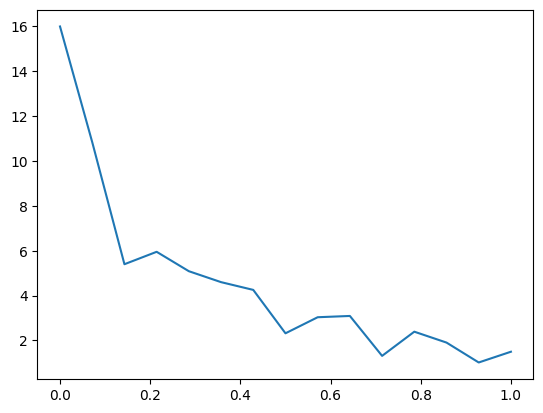

In [53]:
params = backend.implicit_randn([3])
def func(a, b, c):
    dmc = tc.Circuit(1)
    dmc.r(0, theta=a, alpha=b, phi=c)
    return dmc.state()
df = backend.jacrev(func, [0])
print(df(1.0, 1.0, 1.0))